<a href="https://colab.research.google.com/github/dean-sh/Movie-Ratings-Collaborating-Filltering/blob/master/7%20-%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MovieLens Recommendations
=============================================

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.


## ToDo

*   Finished - CF from scratch: grid search and calculate MSE, MAE
*   Dedi - Try Surprise (Can it produce a pivot table? Do we need a pivot table?! Can it recommend top 10 movies?)
*   Dean - Hopefully try Keras and Embeddings, add metadata
*   Build a Flask site
*   Recommend movies to new users - re-train the model for each new user
*   Try new movielens versions



## Data Description




Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.

allbut.pl  -- The script that generates training and test sets where
              all but n of a users ratings are in the training data.

mku.sh     -- A shell script to generate all the u data sets from u.data.

#Imports

---



In [0]:
import numpy as np
import pandas as pd
import collections
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
    """Returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols


# # Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

# **Get the Data**

---



In [2]:
# download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

print("Downloading movielens data...")
import zipfile
import urllib.request

urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [0]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')


Some Preproccessing

In [0]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
        get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
        get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [0]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [6]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,Animation,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller


In [7]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [8]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


In [9]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,Action,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


# EDA



In [12]:
#Identify most popular items

movielens.groupby('title')['rating'].count().sort_values(ascending = False).head(20)

title
Star Wars (1977)                    583
Contact (1997)                      509
Fargo (1996)                        508
Return of the Jedi (1983)           507
Liar Liar (1997)                    485
English Patient, The (1996)         481
Scream (1996)                       478
Toy Story (1995)                    452
Air Force One (1997)                431
Independence Day (ID4) (1996)       429
Raiders of the Lost Ark (1981)      420
Godfather, The (1972)               413
Pulp Fiction (1994)                 394
Twelve Monkeys (1995)               392
Silence of the Lambs, The (1991)    390
Jerry Maguire (1996)                384
Chasing Amy (1997)                  379
Rock, The (1996)                    378
Empire Strikes Back, The (1980)     367
Star Trek: First Contact (1996)     365
Name: rating, dtype: int64

In [17]:
pd.DataFrame(df.groupby('title')['rating'].mean()).sort_values(by='rating', ascending = False).head(10)

,rating
title,
They Made Me a Criminal (1939),5.0
Marlene Dietrich: Shadow and Light (1996),5.0
"Saint of Fort Washington, The (1993)",5.0
Someone Else's America (1995),5.0
Star Kid (1997),5.0
"Great Day in Harlem, A (1994)",5.0
Aiqing wansui (1994),5.0
Santa with Muscles (1996),5.0
Prefontaine (1997),5.0


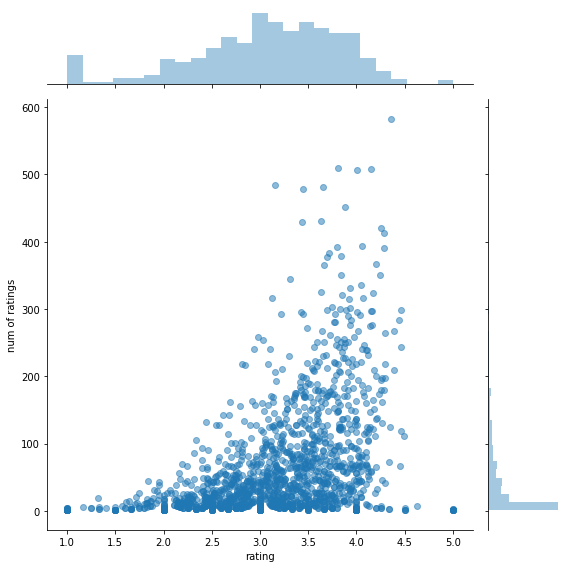

In [18]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5,height = 8)

In [19]:
users.describe(include=[np.object])

,user_id,sex,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,650,M,student,55414
freq,1,670,196,9


In [20]:
movies.describe(include=[np.object])

,movie_id,title,release_date,imdb_url,year,genre,all_genres
count,1682,1682,1681,1679,1682,1682,1682
unique,1682,1664,240,1660,72,19,216
top,650,"Butcher Boy, The (1998)",01-Jan-1995,http://us.imdb.com/M/title-exact?Chasing+Amy+(...,1996,Drama,Drama
freq,1,2,215,2,355,547,376


In [21]:
pd.concat([users.describe() , movies.describe()], axis=1)

,age,video_release_date,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,943.000000,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,34.051962,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,12.192740,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,7.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,43.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,73.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Users Histograms

In [0]:
# The following functions are used to generate interactive Altair charts.
# We will display histograms of the data, sliced by a given attribute.

# Create filters to be used to slice the data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
    """Creates a layered chart of histograms.
    The first layer (light gray) contains the histogram of the full data, and the
    second contains the histogram of the filtered data.
    Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
    """
    base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
    ).properties(
      width=300,
    )
    return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
    ).resolve_scale(y='independent')


In [27]:
ratings

,rating,num of ratings
title,,
'Til There Was You (1997),2.333,9
1-900 (1994),2.600,5
101 Dalmatians (1996),2.908,109
12 Angry Men (1957),4.344,125
187 (1997),3.024,41
...,...,...
Young Guns II (1990),2.773,44
"Young Poisoner's Handbook, The (1995)",3.341,41
Zeus and Roxanne (1997),2.167,6


In [0]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

### Movie Histograms

In [0]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [0]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804
99,Fargo (1996),508,4.156
180,Return of the Jedi (1983),507,4.008
293,Liar Liar (1997),485,3.157
285,"English Patient, The (1996)",481,3.657
287,Scream (1996),478,3.441
0,Toy Story (1995),452,3.878
299,Air Force One (1997),431,3.631
120,Independence Day (ID4) (1996),429,3.438


Masking movies with less than 20 ratings

In [0]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


In [0]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

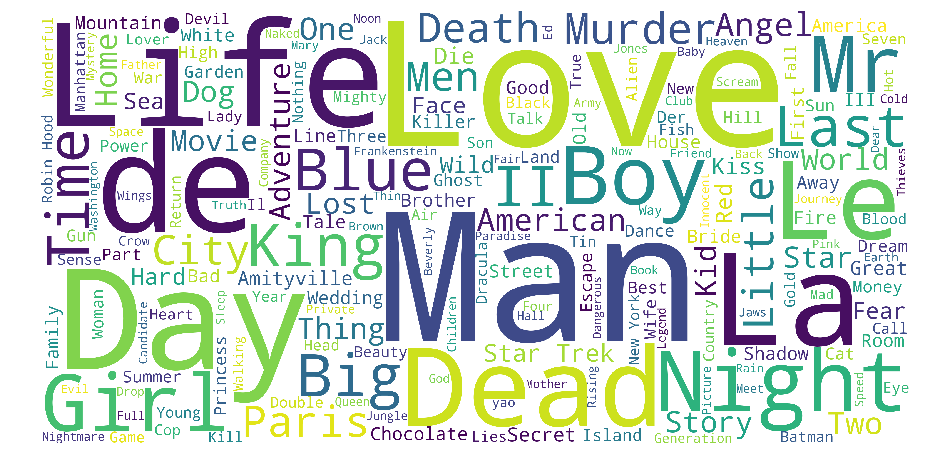

In [0]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

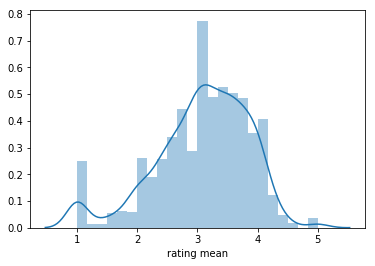

In [0]:
sns.distplot(movies_ratings['rating mean']);
#dist plot of the rating mean of each movie